In [3]:
from FeatureExtraction import *
import os

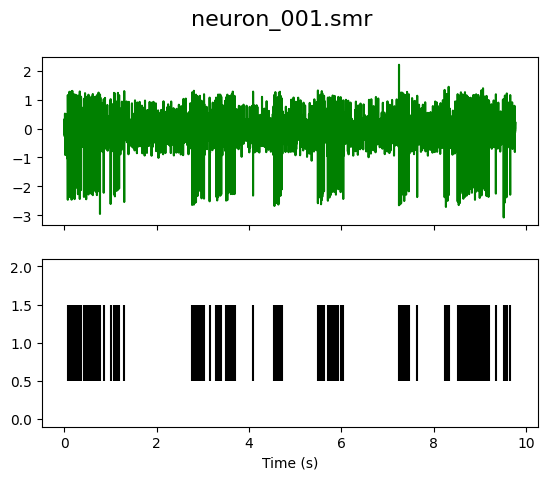

In [4]:
analogsignal, spike_times, sampling_frequency, time = load_spiketrain('/Users/jazlynn/Downloads/neurons-smr-format-sorted/neuron_001.smr', to_plot=True)

In [5]:
data_dir = '/Users/jazlynn/Downloads/neurons-smr-format-sorted/'
for file in os.listdir(data_dir):
    if file.endswith('.smr'):
        analogsignal, spike_times, sampling_frequency, time = load_spiketrain(os.path.join(data_dir,file))